In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from scipy import linalg
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/vuhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Data Preparation

- Clean and tokenize the corpus.

- Extract the pairs of context words and center word that will make up the training data set for the CBOW model. The context words are the features that will be fed into the model, and the center words are the target values that the model will learn to predict.

- Create simple vector representations of the context words (features) and center words (targets) that can be used by the neural network of the CBOW model.

## 1.1 Cleaning and Tokenization

First, replace all interrupting punctuation signs — such as commas and exclamation marks — with periods.

Next, use NLTK's tokenization engine to split the corpus into individual tokens.

Finally, get rid of numbers and punctuation other than periods, and convert all the remaining tokens to lowercase.

In [2]:
def tokenize(corpus):
    data = re.sub(r'[,!?;-]+', '.', corpus)
    data = nltk.word_tokenize(data)
    data = [char.lower() for char in data
           if char.isalpha()
           or char == '.'
           or emoji.get_emoji_regexp().search(char)
           ]
    return data

In [3]:
corpus = 'I am happy because I am learning continuous bags of word for words embeddings ❤️!!!'

words = tokenize(corpus)
words

['i',
 'am',
 'happy',
 'because',
 'i',
 'am',
 'learning',
 'continuous',
 'bags',
 'of',
 'word',
 'for',
 'words',
 'embeddings',
 '❤️',
 '.']

## 1.2 Slicing window of words

Now that we have transformed the corpus into a list of clean tokens, we can slide a window of words across this list. For each window we can extract a center word and the context words.

The first argument of this function is a list of words (or tokens). The second argument, `C`, is the context half-size. Recall that for a given center word, the context words are made of `C` words to the left and `C` words to the right of the center word.

In [4]:
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[i-C:i] + words[i+1:i+C+1]
        yield context_words, center_word
        i += 1

In [5]:
for x, y in get_windows(tokenize(corpus), 1):
    print(x, y)

['i', 'happy'] am
['am', 'because'] happy
['happy', 'i'] because
['because', 'am'] i
['i', 'learning'] am
['am', 'continuous'] learning
['learning', 'bags'] continuous
['continuous', 'of'] bags
['bags', 'word'] of
['of', 'for'] word
['word', 'words'] for
['for', 'embeddings'] words
['words', '❤️'] embeddings
['embeddings', '.'] ❤️


## 1.3 Transforming word into vectors for training set

### 1.3.1 Mapping words to indices and indices to words

The center words will be represented as one-hot vectors, and the vectors that represent context words are also based on one-hot vectors.

To create one-hot word vectors, we can start by mapping each unique word to a unique integer (or index).

In [6]:
def get_dict(data):
    """
    Input:
        data: the data want to pull from
    Output:
        word2idx: returns dictionary mapping the word to its index
        idx2word: returns dictionary mapping the index to its word
    """
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    word2idx = {}
    idx2word = {}
    for k in words:
        word2idx[k] = idx
        idx2word[idx] = k
        idx += 1
    return word2idx, idx2word

In [7]:
word2idx, idx2word = get_dict(words)

print(word2idx)
print()
print(idx2word)

{'.': 0, 'am': 1, 'bags': 2, 'because': 3, 'continuous': 4, 'embeddings': 5, 'for': 6, 'happy': 7, 'i': 8, 'learning': 9, 'of': 10, 'word': 11, 'words': 12, '❤️': 13}

{0: '.', 1: 'am', 2: 'bags', 3: 'because', 4: 'continuous', 5: 'embeddings', 6: 'for', 7: 'happy', 8: 'i', 9: 'learning', 10: 'of', 11: 'word', 12: 'words', 13: '❤️'}


### 1.3.2 Getting one-hot vectors

In [8]:
def word_to_one_hot_vector(word, word2idx, V):
    """
    Input:
        word: the letter of corpus want to transform into one hot vector
        word2idx: dictionary with key is word and value is index of word in string
        V: size of vocabulary
    Output:
        one_hot_vector: a vector one hot of word
    """
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2idx[word]] = 1
    
    return one_hot_vector

In [9]:
word_to_one_hot_vector('word', word2idx, len(word2idx))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

### 1.3.3 Getting context words vectors

To create the vectors that represent context words, we will calculate the average of the one-hot vectors representing the individual words.

In [10]:
def context_words_to_vector(context_words, word2idx, V):
    """
    Input:
        context_words: list of context words
        word2idx: dictionary with key is word and value is index of word in string
        V: size of vocabulary
    Output:
        context_words_vector: vectors of all context words
    """
    context_words_vectors = [word_to_one_hot_vector(w, word2idx, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    
    return context_words_vectors

In [11]:
context_words_to_vector(['am', 'continuous'], word2idx, len(word2idx))

array([0. , 0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. ])

## 1.4 Building the training set

To do this we need to use the sliding window function (`get_windows`) to extract the context words and center words, and we then convert these sets of words into a basic vector representation using `word_to_one_hot_vector` and `context_words_to_vector`.

In [12]:
def get_training_example(words, C, word2idx, V):
    for context_words, center_word in get_windows(words, C):
        yield context_words_to_vector(context_words, word2idx, V),\
              word_to_one_hot_vector(center_word, word2idx, V)

In [13]:
V = len(word2idx)
for context_words_vector, center_word_vector in get_training_example(words[:8], 2, word2idx, V):
    print(f'Context words vector:  {context_words_vector}')
    print(f'Center word vector:  {center_word_vector}')
    print()

Context words vector:  [0.   0.25 0.   0.25 0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.  ]
Center word vector:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

Context words vector:  [0.   0.5  0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.   0.   0.  ]
Center word vector:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Context words vector:  [0.   0.25 0.   0.25 0.   0.   0.   0.25 0.   0.25 0.   0.   0.   0.  ]
Center word vector:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Context words vector:  [0.   0.   0.   0.25 0.25 0.   0.   0.   0.25 0.25 0.   0.   0.   0.  ]
Center word vector:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



## 1.5 Deviding training set into batches

In [14]:
def get_idx(words, word2idx):
    idx = []
    for word in words:
        idx = idx + [word2idx[word]]
    return idx

def pack_idx_with_frequency(context_words, word2idx):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2idx)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [15]:
def get_vectors(data, word2idx, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2idx[center_word]] = 1
        context_words = data[(i - C) : i] + data[(i + 1) : (i + C + 1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2idx):
            x[idx] = freq / num_ctx_words
        yield x, y
        i += 1
        if i >= len(data) - C:
#             print("i is being set to", C)
            i = C

In [16]:
def get_batches(data, word2idx, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2idx, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

# 2. The shallow neurals network for continuous bag-of-words model

## 2.1 Activation functions

### ReLU

ReLU is used to calculate the values of the hidden layer, in the following formulas:

\begin{align}
 \mathbf{z_1} &= \mathbf{W_1}\mathbf{x} + \mathbf{b_1}  \ \\
 \mathbf{h} &= \mathrm{ReLU}(\mathbf{z_1})  \ \\
\end{align}



In [17]:
def relu(z):
    return np.maximum(0, z)

In [18]:
np.random.seed(42)

z1 = 10 * np.random.rand(5, 1) - 5
z1

array([[-1.25459881],
       [ 4.50714306],
       [ 2.31993942],
       [ 0.98658484],
       [-3.4398136 ]])

In [19]:
relu(z1)

array([[0.        ],
       [4.50714306],
       [2.31993942],
       [0.98658484],
       [0.        ]])

### Softmax

The second activation function that we need is softmax. This function is used to calculate the values of the output layer of the neural network, using the following formulas:

\begin{align}
 \mathbf{z_2} &= \mathbf{W_2}\mathbf{h} + \mathbf{b_2}   \\\
 \mathbf{\hat y} &= \mathrm{softmax}(\mathbf{z_2})   \\\
\end{align}

To calculate softmax of a vector $\mathbf{z}$, the $i$-th component of the resulting vector is given by:

$$ \textrm{softmax}(\textbf{z})_i = \frac{e^{z_i} }{\sum\limits_{j=1}^{V} e^{z_j} }   $$

In [20]:
def softmax(z):
    yhat = np.exp(z) / np.sum(np.exp(z), axis=0)
    
    return yhat

In [21]:
z1 = np.array([9, 8, 11, 10, 8.5])

softmax(z1)

array([0.08276948, 0.03044919, 0.61158833, 0.22499077, 0.05020223])

In [22]:
softmax(z1).sum()

1.0

## 2.2 Cost function

In [23]:
def compute_cost(y, yhat, batch_size):
    loss = np.sum(np.multiply(np.log(yhat), y))
    
    cost = -1/batch_size * loss
    cost = np.squeeze(cost)
    
    return cost

In [24]:
y_pred = softmax(relu(z1))
y_pred

array([0.08276948, 0.03044919, 0.61158833, 0.22499077, 0.05020223])

In [25]:
compute_cost(z1, y_pred, 1)

96.11385871598675

## 2.3 Foward propagation

### 2.3.1 Initialization of the weights and biases

- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in vocabulary and $N$ is the dimension of word vector.
- The second matrix ($W_2$) is of dimension $V \times N$. 
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$. 
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.



In [26]:
V = len(word2idx)
N = 3

In [27]:
def initialize_model(N, V, random_seed=42):
    np.random.seed(random_seed)

    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)
    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)
    
    return W1, W2, b1, b2

In [28]:
def forward_prop(x, W1, W2, b1, b2):
    h = np.dot(W1, x) + b1
    h = relu(h)
    z = np.dot(W2, h) + b2
    
    return z, h

In [29]:
training_exp = get_training_example(words, 2, word2idx, V)

x_arr, y_arr = next(training_exp)

In [30]:
print('X array:', x_arr)
print('Y array', y_arr)

X array: [0.   0.25 0.   0.25 0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.  ]
Y array [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [31]:
x = x_arr.copy().reshape((V, 1))
x

array([[0.  ],
       [0.25],
       [0.  ],
       [0.25],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.5 ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]])

In [32]:
y = y_arr.copy().reshape((V, 1))
y

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [33]:
W1, W2, b1, b2 = initialize_model(N, V)

In [34]:
z, h = forward_prop(x, W1, W2, b1, b2)

print(z)

[[1.50367487]
 [2.23794117]
 [2.04583807]
 [2.34063318]
 [1.99096705]
 [1.29042984]
 [1.90126297]
 [1.81749928]
 [1.2244145 ]
 [2.19518956]
 [1.62344649]
 [1.3229408 ]
 [1.34907424]
 [0.92805151]]


In [35]:
h

array([[0.99888303],
       [0.64829588],
       [0.9361567 ]])

In [36]:
compute_cost(y, softmax(z), 1)

2.606097345651427

## 2.4 Backpropagation

The formulas will implement for backpropagation are the following.

\begin{align}
 \frac{\partial J}{\partial \mathbf{W_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right )\mathbf{x}^\top \\\
 \frac{\partial J}{\partial \mathbf{W_2}} &= (\mathbf{\hat{y}} - \mathbf{y})\mathbf{h^\top} \\\
 \frac{\partial J}{\partial \mathbf{b_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right ) \\\
 \frac{\partial J}{\partial \mathbf{b_2}} &= \mathbf{\hat{y}} - \mathbf{y} \
\end{align}



In [37]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    
    grad_W1 = 1/batch_size * np.dot(relu(np.dot(W2.T, yhat - y)), x.T)
    grad_W2 = 1/batch_size * np.dot(yhat - y, h.T)
    grad_b1 = 1/batch_size * np.dot(relu(np.dot(W2.T, yhat -y)), np.ones((batch_size, 1)))
    grad_b2 = 1/batch_size * np.dot(yhat - y, np.ones((batch_size, 1)))
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [38]:
yhat = softmax(z)

grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, 1)

In [39]:
print('Size of vocabulary: {}'.format(V))
print('Shape of W1: {}'.format(grad_W1.shape))
print('Shape of W2: {}'.format(grad_W2.shape))
print('Shape of b1: {}'.format(grad_b1.shape))
print('Shape of b2: {}'.format(grad_b2.shape))

Size of vocabulary: 14
Shape of W1: (3, 14)
Shape of W2: (14, 3)
Shape of b1: (3, 1)
Shape of b2: (14, 1)


## 2.5 Gradient Descent

During the gradient descent phase, we will update the weights and biases by subtracting $\alpha$ times the gradient from the original matrices and vectors, using the following formulas.

\begin{align}
 \mathbf{W_1} &:= \mathbf{W_1} - \alpha \frac{\partial J}{\partial \mathbf{W_1}} \\\
 \mathbf{W_2} &:= \mathbf{W_2} - \alpha \frac{\partial J}{\partial \mathbf{W_2}} \\\
 \mathbf{b_1} &:= \mathbf{b_1} - \alpha \frac{\partial J}{\partial \mathbf{b_1}} \\\
 \mathbf{b_2} &:= \mathbf{b_2} - \alpha \frac{\partial J}{\partial \mathbf{b_2}} \\\
\end{align}

In [40]:
def gradient_descent(data, word2idx, N, V, num_iters, alpha, batch_sizes,
                     initialize_model=initialize_model, get_batches=get_batches, forward_prop=forward_prop,
                     softmax=softmax, compute_cost=compute_cost, back_prop=back_prop, random_seed=42):
    '''
    
      Inputs: 
        data:      text/list of words
        word2idx:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N, V, random_seed=random_seed)
    batch_size = batch_sizes
    
    iters = 0
    C = 2
    
    for x, y in get_batches(data, word2idx, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        
        yhat = softmax(z)
        
        cost = compute_cost(y, yhat, batch_size)
        if (iters) % 10 == 0 and iters != 0:
            print('Iters: {} cost: {:.5f}'.format(iters, cost))
        
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2
        
        iters += 1
        if iters == num_iters:
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [45]:
N = 10
V = len(word2idx)
num_iters = 300
alpha = 0.03
batch_sizes = 1

W1, W2, b1, b2 = gradient_descent(words, word2idx, N, V, num_iters, alpha, batch_sizes)

Iters: 10 cost: 2.41922
Iters: 20 cost: 2.90396
Iters: 30 cost: 3.13578
Iters: 40 cost: 3.26347
Iters: 50 cost: 2.28515
Iters: 60 cost: 2.50531
Iters: 70 cost: 2.30940
Iters: 80 cost: 2.49927
Iters: 90 cost: 2.62349
Iters: 100 cost: 2.79418
Iters: 110 cost: 2.23276
Iters: 120 cost: 2.49900
Iters: 130 cost: 2.32018
Iters: 140 cost: 2.41170
Iters: 150 cost: 2.48986
Iters: 160 cost: 2.63515
Iters: 170 cost: 2.23168
Iters: 180 cost: 2.52124
Iters: 190 cost: 2.36628
Iters: 200 cost: 2.37304
Iters: 210 cost: 2.38228
Iters: 220 cost: 2.52324
Iters: 230 cost: 2.26360
Iters: 240 cost: 2.54000
Iters: 250 cost: 2.40891
Iters: 260 cost: 2.39060
Iters: 270 cost: 2.32906
Iters: 280 cost: 2.50040
Iters: 290 cost: 2.29496


# 3. Extracting & Visualizing word embedding vectors

### Option 1: extract embedding vectors from $\mathbf{W_1}$

In [46]:
W1.shape

(10, 14)

In [47]:
W1

array([[ 0.29646731,  0.92134604,  0.67322541,  0.59351037,  0.13294828,
         0.14753321, -0.0632072 ,  0.86589602,  0.59106657,  0.6608144 ,
        -0.0612544 ,  0.93837818,  0.71961313,  0.12580499],
       [ 0.18182497, -0.01217035,  0.23453102,  0.4830255 ,  0.38942226,
         0.23884338,  0.59591917,  0.06794761,  0.17929755,  0.27351354,
         0.33620639,  0.73243669,  0.13135429,  0.51423444],
       [ 0.59241457, -0.02267047,  0.607166  ,  0.04732807,  0.00511449,
         0.86076138,  0.91912919,  0.74267101,  0.24119741, -0.02506037,
         0.64261171,  0.35202833,  0.08041692,  0.44867407],
       [ 0.03438852,  0.79155724,  0.20415943,  0.6067866 ,  0.27870388,
         0.51805758,  0.49056391,  0.13093184,  0.87206361,  0.75067889,
         0.91528011,  0.86248629,  0.57388791,  0.91986379],
       [ 0.07369392,  0.11812929, -0.09589932,  0.2972626 ,  0.26254565,
         0.27134903,  0.72259815,  0.32868559,  0.25384416,  0.45322362,
         0.04851076,  0.70

The first column, which is a 3-element vector, is the embedding vector of the first word of your vocabulary. The second column is the word embedding vector for the second word, and so on.

The first, second, etc. words are ordered as follows.

In [48]:
for word in word2idx:
    word_embedding_vector = W1[:, word2idx[word]]
    print('{}:  {}'.format(word, word_embedding_vector))

.:  [0.29646731 0.18182497 0.59241457 0.03438852 0.07369392 0.75684689
 0.31098232 0.02541913 0.92969765 0.81801477]
am:  [ 0.92134604 -0.01217035 -0.02267047  0.79155724  0.11812929  0.06316786
  0.2592993  -0.04652125  0.80484395  0.72542441]
bags:  [ 0.67322541  0.23453102  0.607166    0.20415943 -0.09589932  0.00552212
  0.66707364 -0.03973275  0.62919429 -0.10443147]
because:  [0.59351037 0.4830255  0.04732807 0.6067866  0.2972626  0.73166165
 0.60179553 0.60907981 0.82983326 0.51048552]
continuous:  [0.13294828 0.38942226 0.00511449 0.27870388 0.26254565 0.68148896
 0.79822436 0.19748185 0.69912161 0.38683852]
embeddings:  [0.14753321 0.23884338 0.86076138 0.51805758 0.27134903 0.6772796
 0.41530125 0.50851424 0.08001342 0.15417013]
for:  [-0.0632072   0.59591917  0.91912919  0.49056391  0.72259815  0.75587247
  0.08718378  0.90756647  0.85890431  0.0368791 ]
happy:  [0.86589602 0.06794761 0.74267101 0.13093184 0.32868559 0.00567837
 0.71324479 0.19400156 0.53934224 0.29935847]
i

### Option 2: extract embedding vectors from $\mathbf{W_2}$

In [49]:
W2.T

array([[ 0.78514847,  0.90441464,  0.44723294,  0.89303439,  0.52618256,
         0.0017279 ,  0.70221691,  0.66081036,  0.70489065,  1.03789443,
         0.86138779,  0.34561109,  0.50954088,  0.27260226],
       [ 0.2224908 ,  0.24806641,  0.71459033, -0.00965601,  0.12573573,
         0.8757447 ,  0.14207805,  0.67352305,  0.53109243,  0.53089596,
         0.97254448,  0.41943493,  1.04160604,  0.64895465],
       [ 0.45049662,  0.05304395,  0.63592102,  0.50729057,  0.94739371,
         0.94597347,  0.27291   ,  0.57984851,  0.03723984,  0.59130752,
         0.92543099,  0.98861039,  0.26973917,  0.66499809],
       [ 0.23155445,  0.49238121,  0.631656  ,  0.28844502,  0.96829109,
         0.55941876,  0.98713538,  0.34041681,  0.31454778,  0.54851574,
         0.25568095,  0.33503269,  0.54358576,  0.6680886 ],
       [ 0.21561687,  0.99528516,  0.20072248,  0.63954194,  0.25993206,
         0.38231041,  0.63712538,  0.67660207,  0.24480173,  0.23640647,
         0.02758894,  0.17

In [50]:
for word in word2idx:
    word_embedding_vector = W2.T[:, word2idx[word]]
    print('{}:  {}'.format(word, word_embedding_vector))

.:  [ 0.78514847  0.2224908   0.45049662  0.23155445  0.21561687  0.01900293
  0.51323852  0.42915222 -0.01517273  0.18884514]
am:  [0.90441464 0.24806641 0.05304395 0.49238121 0.99528516 0.25480448
 0.7563723  0.86168929 0.3463524  0.7585913 ]
bags:  [0.44723294 0.71459033 0.63592102 0.631656   0.20072248 0.90090312
 0.46076165 0.24874897 0.05399861 0.66561759]
because:  [ 0.89303439 -0.00965601  0.50729057  0.28844502  0.63954194  0.13989564
  0.71555489  0.35152249  1.03612109  0.30427531]
continuous:  [0.52618256 0.12573573 0.94739371 0.96829109 0.25993206 0.64105421
 0.92881516 0.58579223 0.61926796 0.28315213]
embeddings:  [0.0017279  0.8757447  0.94597347 0.55941876 0.38231041 0.34539498
 0.61606529 0.90227309 0.86277308 0.79592261]
for:  [ 0.70221691  0.14207805  0.27291     0.98713538  0.63712538  0.10425481
  0.16802052  0.69197639 -0.09994319  0.19496933]
happy:  [0.66081036 0.67352305 0.57984851 0.34041681 0.67660207 0.23307817
 0.37498195 0.78107262 0.76419123 1.02398756]


### Option 3: extract embedding vectors from $\mathbf{W_1}$ and $\mathbf{W_2}$

**Calculate the average of $\mathbf{W_1}$ and $\mathbf{W_2^\top}$, and store the result in `W3`.**

In [51]:
W3 = (W1+W2.T)/2

W3

array([[0.54080789, 0.91288034, 0.56022917, 0.74327238, 0.32956542,
        0.07463056, 0.31950485, 0.76335319, 0.64797861, 0.84935442,
        0.4000667 , 0.64199464, 0.61457701, 0.19920362],
       [0.20215788, 0.11794803, 0.47456067, 0.23668475, 0.257579  ,
        0.55729404, 0.36899861, 0.37073533, 0.35519499, 0.40220475,
        0.65437544, 0.57593581, 0.58648016, 0.58159454],
       [0.52145559, 0.01518674, 0.62154351, 0.27730932, 0.4762541 ,
        0.90336743, 0.5960196 , 0.66125976, 0.13921862, 0.28312357,
        0.78402135, 0.67031936, 0.17507804, 0.55683608],
       [0.13297149, 0.64196923, 0.41790772, 0.44761581, 0.62349749,
        0.53873817, 0.73884965, 0.23567433, 0.5933057 , 0.64959731,
        0.58548053, 0.59875949, 0.55873683, 0.79397619],
       [0.14465539, 0.55670723, 0.05241158, 0.46840227, 0.26123886,
        0.32682972, 0.67986177, 0.50264383, 0.24932294, 0.34481504,
        0.03804985, 0.43839268, 0.53114374, 0.60231221],
       [0.38792491, 0.15898617, 0.4

In [52]:
for word in word2idx:
    word_embedding_vector = W3[:, word2idx[word]]
    print('{}:  {}'.format(word, word_embedding_vector))

.:  [0.54080789 0.20215788 0.52145559 0.13297149 0.14465539 0.38792491
 0.41211042 0.22728567 0.45726246 0.50342995]
am:  [0.91288034 0.11794803 0.01518674 0.64196923 0.55670723 0.15898617
 0.5078358  0.40758402 0.57559818 0.74200786]
bags:  [0.56022917 0.47456067 0.62154351 0.41790772 0.05241158 0.45321262
 0.56391764 0.10450811 0.34159645 0.28059306]
because:  [0.74327238 0.23668475 0.27730932 0.44761581 0.46840227 0.43577864
 0.65867521 0.48030115 0.93297717 0.40738042]
continuous:  [0.32956542 0.257579   0.4762541  0.62349749 0.26123886 0.66127159
 0.86351976 0.39163704 0.65919478 0.33499533]
embeddings:  [0.07463056 0.55729404 0.90336743 0.53873817 0.32682972 0.51133729
 0.51568327 0.70539367 0.47139325 0.47504637]
for:  [0.31950485 0.36899861 0.5960196  0.73884965 0.67986177 0.43006364
 0.12760215 0.79977143 0.37948056 0.11592421]
happy:  [0.76335319 0.37073533 0.66125976 0.23567433 0.50264383 0.11937827
 0.54411337 0.48753709 0.65176674 0.66167302]
i:  [0.64797861 0.35519499 0.1

### Visualizing the Word Vectors

In [53]:
embs = (W1 + W2.T) / 2

idx = [word2idx[word] for word in list(word2idx.keys())]

X_embs = embs[:, idx]

In [54]:
X_embs

array([[0.54080789, 0.91288034, 0.56022917, 0.74327238, 0.32956542,
        0.07463056, 0.31950485, 0.76335319, 0.64797861, 0.84935442,
        0.4000667 , 0.64199464, 0.61457701, 0.19920362],
       [0.20215788, 0.11794803, 0.47456067, 0.23668475, 0.257579  ,
        0.55729404, 0.36899861, 0.37073533, 0.35519499, 0.40220475,
        0.65437544, 0.57593581, 0.58648016, 0.58159454],
       [0.52145559, 0.01518674, 0.62154351, 0.27730932, 0.4762541 ,
        0.90336743, 0.5960196 , 0.66125976, 0.13921862, 0.28312357,
        0.78402135, 0.67031936, 0.17507804, 0.55683608],
       [0.13297149, 0.64196923, 0.41790772, 0.44761581, 0.62349749,
        0.53873817, 0.73884965, 0.23567433, 0.5933057 , 0.64959731,
        0.58548053, 0.59875949, 0.55873683, 0.79397619],
       [0.14465539, 0.55670723, 0.05241158, 0.46840227, 0.26123886,
        0.32682972, 0.67986177, 0.50264383, 0.24932294, 0.34481504,
        0.03804985, 0.43839268, 0.53114374, 0.60231221],
       [0.38792491, 0.15898617, 0.4

In [55]:
X_embs.shape

(10, 14)

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_embs.T)

X_reduced = pca.transform(X_embs.T)

In [57]:
X_reduced.shape

(14, 2)

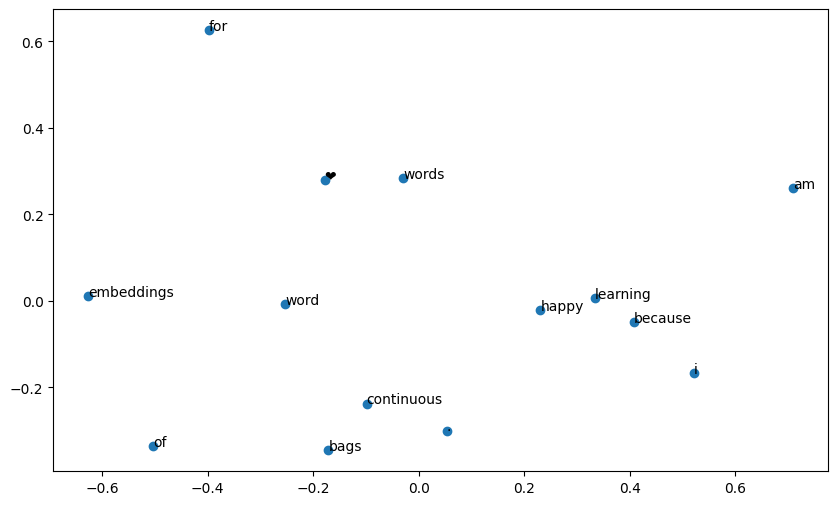

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i, word in idx2word.items():
    plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]))
plt.show()